In [1]:
from sklearn.model_selection import KFold. train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import lazyqsar as lq
from rdkit.Chem import PandasTools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 16

In [2]:
#Your dataset path
import os
filename = '/content/Final_processed.csv'
#current_directory = os.path.dirname(__file__)
#filename = os.path.join(current_directory, "..", "Data", "My_data", "Final_processed.csv")

In [3]:
import pandas as pd
df = pd.read_csv(filename)

In [ ]:
#Visualizing our data
df

In [5]:
df.shape

(265, 3)

In [6]:
SMILES = "SMILES"
EXP = "Active"

In [7]:
import matplotlib.pyplot as plt
x = df[EXP]
print(x)

0      1
1      1
2      0
3      0
4      0
      ..
260    1
261    0
262    0
263    0
264    0
Name: Active, Length: 265, dtype: int64


(array([119.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 146.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

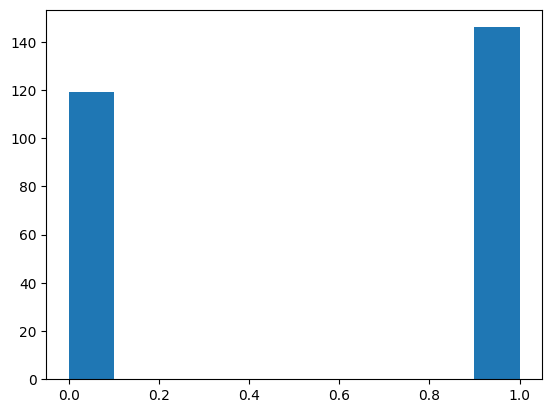

In [8]:
#Plotting to see the distribution of active and inactive we have in our dataset
plt.hist(x)

In [10]:
print("Total molecules: ", len(df))
print("Active molecules: ", len(df[df[EXP]==1]))
print("Inactive molecules: ", len(df[df[EXP]==0]))
print("Frequency of Actives (%): ", len(df[df[EXP]==1])/len(df)*100)

Total molecules:  265
Active molecules:  146
Inactive molecules:  119
Frequency of Actives (%):  55.094339622641506


In [14]:
# Assuming SMILES and EXP are defined earlier in your code
SMILES = 'SMILES'
EXP = 'Active'

def random_split(df, size):
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(df[SMILES], df[EXP], indices, test_size=size, stratify=df[EXP])
    train = df.iloc[i_train]
    test = df.iloc[i_test]
    return train, test

In [ ]:
for i in range(5):
    train, test = random_split(df, 0.2)
    train.to_csv(os.path.join(DATAPATH, "train_test_splits", "train_{}.csv".format(i)), index=False)
    test.to_csv(os.path.join(DATAPATH, "train_test_splits", "test_{}.csv".format(i)), index=False)

In [15]:
def preprocess_and_generate_fingerprints(df):
    smiles = df[SMILES]
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]

    # Filter out None molecules
    valid_mols = [mol for mol in mols if mol is not None]

    # Specify the radius and number of bits for Morgan fingerprint
    radius = 3
    nBits = 2048

    # Generate Morgan fingerprints for valid molecules
    fps = []

    for mol in valid_mols:
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
            fps.append(np.array(list(fp.ToBitString())).astype(int))
        except:
            # Handle any exceptions, e.g., if the fingerprint calculation fails for a specific molecule
            print(f"Failed to generate fingerprint for molecule: {Chem.MolToSmiles(mol)}")

    return fps



In [16]:
def cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Convert Morgan fingerprints to SMILES strings
        smiles_train = ["".join(map(str, x)) for x in X_train]
        smiles_test = ["".join(map(str, x)) for x in X_test]

        # Train the model
        model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
        model.fit(smiles_train, y_train)

        # Predict probabilities
        y_pred_proba = model.predict_proba(smiles_test)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculate accuracy for this fold and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    # Calculate and print the average accuracy across all folds
    average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    print("Average Accuracy:", average_accuracy)


train, test = random_split(df, 0.2)

# Preprocess and generate fingerprints for the training set
morgan_fps_train = preprocess_and_generate_fingerprints(train)

# Separate features (fingerprints) and target variable (EXP)
X_train = np.array(morgan_fps_train)
y_train = train[EXP]

# Perform 5-fold cross-validation
cross_validation(X_train, y_train)


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetHashedMorganFingerprint(NoneType)
did not match C++ signature:
    GetHashedMorganFingerprint(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

### The ROC-AUC curve

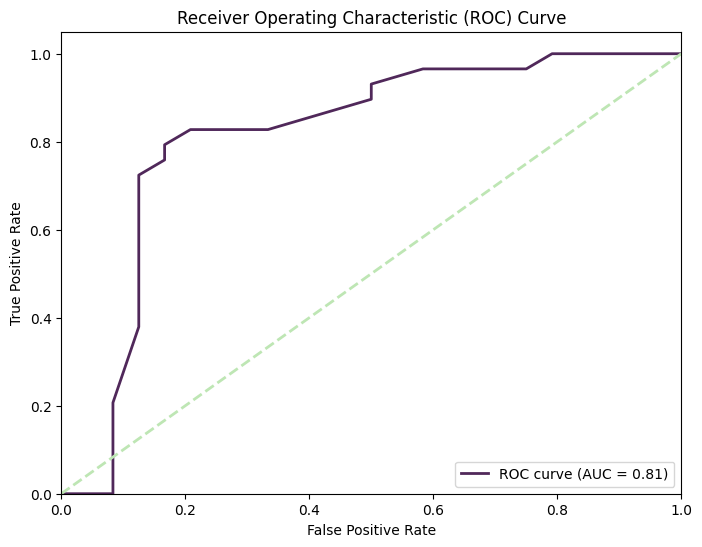

In [ ]:
from sklearn.metrics import roc_curve, auc

# We need the real results, the activity of the test set
y_test = test[EXP]

# We use the sklearn package to calculate the roc_curve and plot it
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[Text(0, 0.5, 'Inactive'), Text(0, 1.5, 'Active')]

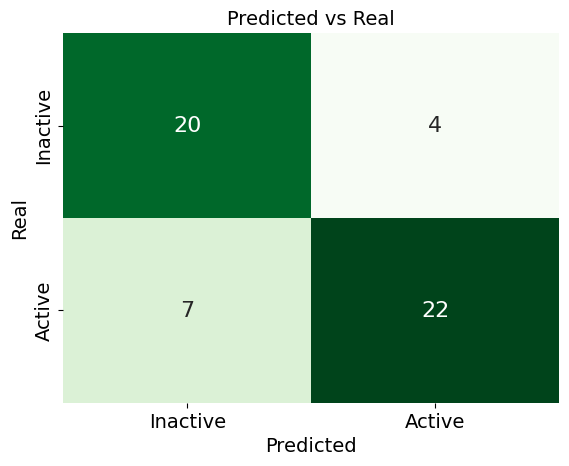

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

proba_cutoff = 0.5
y_hat_bin = [1 if x >= proba_cutoff else 0 for x in y_hat]


cf_matrix = confusion_matrix(y_test, y_hat_bin)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_hat_bin))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        24
           1       0.85      0.76      0.80        29

    accuracy                           0.79        53
   macro avg       0.79      0.80      0.79        53
weighted avg       0.80      0.79      0.79        53



In [ ]:
model.save("model_morgan.joblib")